## Sliding velocity: Mendenhall Glacier

In this notebook, we will estimate the sliding velocity for a temperate, alpine glacier, using surface velocity measurements and the shallow-ice approximation. To do so, we assume that, generally, surface velocity is the sum of deformation velocity and sliding velocity.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

from landlab import RasterModelGrid
from landlab.components import GlacierMassBalancer
from landlab.plot import imshow_grid

### Step 1) Read input files

In [7]:
surface_velocity_x_file = './data/inputs/velocity_x.tif'
surface_velocity_y_file = './data/inputs/velocity_y.tif'
surface_elevation_file = './data/inputs/surface_elevation.tif'
ice_thickness_file = './data/inputs/ice_thickness.tif'

In [8]:
variables = ['surface_velocity_x', 'surface_velocity_y', 'ice_thickness', 'surface_elevation']
fields = {i: None for i in variables}

for var in variables:
    file = './data/inputs/' + var + '.tif'
    
    with rio.open(file) as f:
        raw_data = f.read(1)
        data = np.flip(raw_data, axis = 0)
        
        fields[var] = data

### Step 2) Set up RasterModelGrid

In [9]:
grid = RasterModelGrid(fields['ice_thickness'].shape, 50.)

bed_z = fields['surface_elevation'] - fields['ice_thickness']
grid.add_field('glacier__bed_elevation', bed_z, at = 'node', clobber = True)

grid.add_field('glacier__thickness', fields['ice_thickness'], at = 'node', clobber = True)
grid.add_zeros('glacier__specific_mass_balance', at = 'node', clobber = True)

grid.status_at_node[grid.at_node['glacier__thickness'] <= 0] = grid.BC_NODE_IS_CLOSED
pass

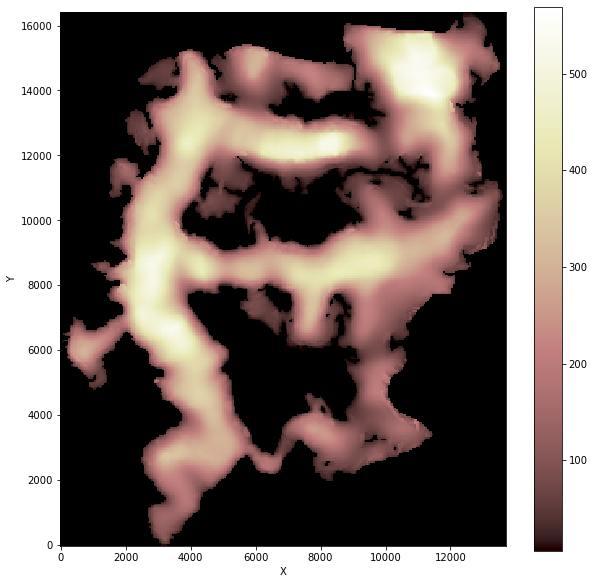

In [10]:
plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'glacier__thickness')

### Step 3) Model the deformation velocity

In [39]:
SIA = GlacierMassBalancer(grid)
SIA.run_one_step(1)

In [41]:
grad_s = grid.map_mean_of_links_to_node(SIA._grad_s)
ice_u = grid.map_mean_of_links_to_node(SIA._ice_u)

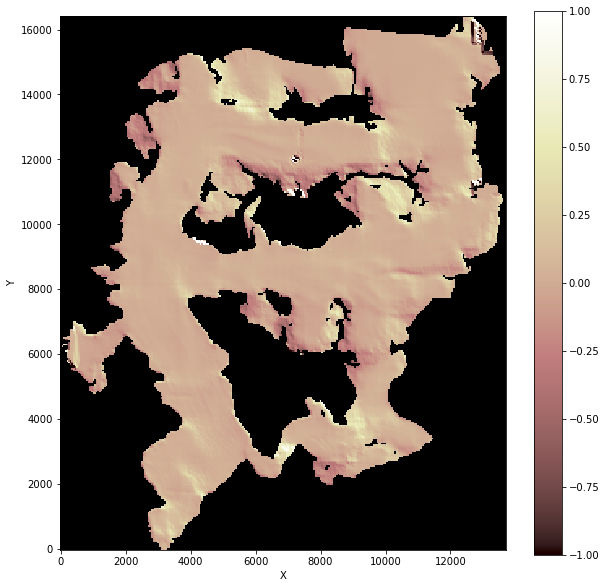

In [45]:
plt.subplots(figsize = (10, 10))
imshow_grid(grid, grad_s, vmax = 1.0, vmin = -1)

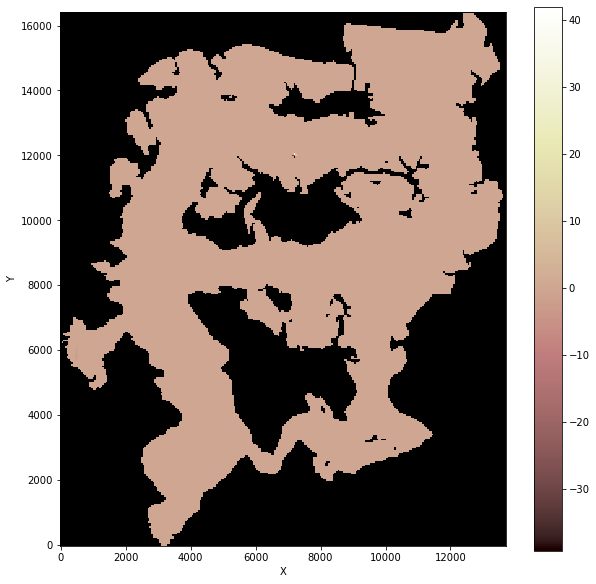

In [46]:
plt.subplots(figsize = (10, 10))
imshow_grid(grid, ice_u)

### Step 4) Compute the sliding velocity

In [14]:
velocity_magnitude = np.sqrt(fields['surface_velocity_x']**2 + fields['surface_velocity_y']**2)
grid.add_field('surface_velocity__magnitude', velocity_magnitude, at = 'node', clobber = True)

sliding = grid.at_node['surface_velocity__magnitude'][:] - ice_u
grid.add_field('sliding_velocity__magnitude', sliding, at = 'node', clobber = True)

pass

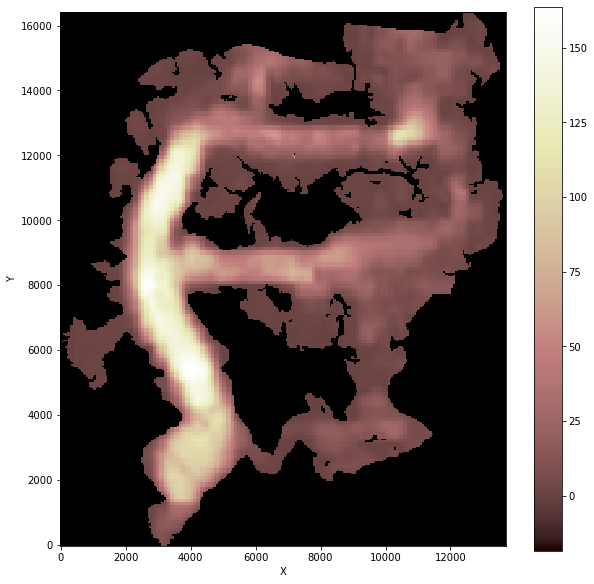

In [15]:
plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'sliding_velocity__magnitude')

### Step 5) Context